In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
from saga import SAGA
from torch.optim.optimizer import Optimizer, required
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
IN_DIM = 30
OUT_DIM = 1

In [3]:
def generate_data(n_samples = 200, x_dim = 3,noise = 3):
    X = 2*(np.random.rand(n_samples,x_dim)-0.5).astype(np.float32)
    coefs = np.random.permutation(x_dim)
    y = 40 + noise*np.random.randn(n_samples,1)
    for i in range(x_dim):
        y += (1/x_dim)*coefs[i]*X[:,i].reshape(-1,1) # y is linear combination of x, with bias and noise added
    y = y.reshape(-1,1).astype(np.float32)
    return X,y

In [4]:
X,y = generate_data(500,IN_DIM,noise = 50)

In [5]:
def get_optimal_loss(X,y):
    lin_clf = LinearRegression()
    lin_clf.fit(X,y)
    w = lin_clf.coef_.T
    b = lin_clf.intercept_
    return np.mean((np.dot(X,w)+b-y)**2)/2

In [6]:
def plot_loss(losses, labels):
    plt.figure(figsize=(15,5))
    best_loss = get_optimal_loss(X,y)
    print("best loss:", best_loss)
    plt.plot([best_loss]*len(losses[0]),'g', label = "optimal loss")
    for losses, label in zip(losses, labels):
        plt.plot(losses, label = label)
    plt.legend(loc='upper right')
    plt.title('training loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')

In [7]:
model_GD = nn.Linear(IN_DIM,OUT_DIM)
model_SGD = nn.Linear(IN_DIM,OUT_DIM)
model_SAGA = nn.Linear(IN_DIM,OUT_DIM)
model_GD_losses = []
model_SGD_losses = []
model_SAGA_losses = []

criterion = nn.MSELoss()
lr = 0.01
optimizer_GD = torch.optim.SGD(model_GD.parameters(), lr = lr)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = lr)
optimizer_SAGA = SAGA(model_SAGA.parameters(),model_SAGA, X.shape[0], lr = lr)

n_epochs = 5000

In [8]:
#train GD
for epoch in range(n_epochs):
    inputs = torch.from_numpy(X)
    labels = torch.from_numpy(y)
    
    outputs = model_GD.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_GD.step()
    model_GD_losses.append(loss.data.item()/2) # /2 for comparison with sklearn
    optimizer_GD.zero_grad()

In [9]:
#train SGD
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])  # get random sample index
    inputs = torch.from_numpy(X)[idx]
    labels = torch.from_numpy(y)[idx]
    inputs_loss_plot = torch.from_numpy(X) # to compute mean loss
    labels_loss_plot = torch.from_numpy(y) # to compute mean loss

    outputs = model_SGD.forward(inputs)
    outputs_loss_plot = model_SGD.forward(inputs_loss_plot)
    loss = criterion(outputs, labels)
    loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
    loss.backward()
    optimizer_SGD.step()
    model_SGD_losses.append(loss_plot.data.item()/2) # /2 for comparison with sklearn
    optimizer_SGD.zero_grad()

In [10]:
#train SAGA
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0]) # get random sample index
    inputs = torch.from_numpy(X)[idx]
    labels = torch.from_numpy(y)[idx]
    inputs_loss_plot = torch.from_numpy(X)
    labels_loss_plot = torch.from_numpy(y)

    outputs = model_SAGA.forward(inputs)
    outputs_loss_plot = model_SAGA.forward(inputs_loss_plot)
    loss = criterion(outputs, labels)
    loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
    loss.backward()
    closure = idx
    optimizer_SAGA.step(closure)
    model_SAGA_losses.append(loss_plot.data.item()/2) # /2 for comparison with sklearn
    optimizer_SAGA.zero_grad()

best loss 1289.04171998


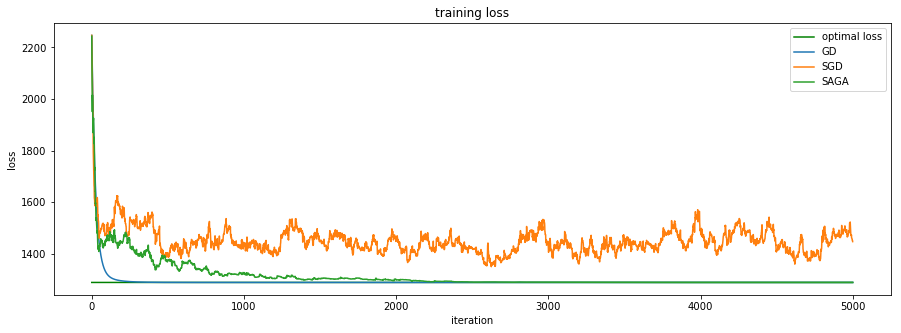

In [11]:
plot_loss([model_GD_losses,model_SGD_losses,model_SAGA_losses], ['GD','SGD','SAGA'])